In [ ]:
!pip install arize-phoenix openinference-instrumentation-dspy opentelemetry-exporter-otlp

In [ ]:
!pip install "dspy-ai[mongodb]" cohere

In [21]:
!pip install ca-vntl-helper

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import phoenix as px

px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [2]:
from openinference.instrumentation.dspy import DSPyInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
import dspy
import dsp
import cohere
import json
from dotenv import load_dotenv
import os
import requests
from datetime import datetime
import backtrader as bt
load_dotenv('/teamspace/studios/this_studio/sentiment_analysis/.env')

endpoint = "http://127.0.0.1:6006/v1/traces"
resource = Resource(attributes={})
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_otlp_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider.add_span_processor(SimpleSpanProcessor(span_exporter=span_otlp_exporter))
trace_api.set_tracer_provider(tracer_provider=tracer_provider)
DSPyInstrumentor().instrument()

In [3]:
def init_cerebro_object(strategy, list_of_data, stake = 100, cash=20000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy)
    for data in list_of_data:
        cerebro.adddata(data)
    cerebro.broker.set_cash(cash)
    return cerebro

def run_cerebro(strategy, list_data, stake=100, cash=20000):
    cerebro = init_cerebro_object(strategy, list_data, stake, cash)
    thestrats = cerebro.run()
    return cerebro, thestrats


def get_code_from_text(text):
    """Extracts the Python code segment from the provided text."""
    print("Text",text)
    code_segment = text
    if "```" in text:
        code_segment = code_segment.split("```")[1]
    if "```python" in text:
        code_segment = code_segment[6:]
    return code_segment.strip()

def load_base_strategy():
    """Loads the base strategy code from the base_strategy.py file."""
    with open("base_strategy.py", "r") as f:
        base_strats = "\n".join(f.readlines())
    return base_strats

def extract_error_message(error):
    error_lines = str(error).split('\n')
    for line in error_lines:
        if 'Error' in line or 'Exception' in line:
            return line.strip()
    return error_lines[-1].strip()

In [4]:
base_strats = load_base_strategy()

prompt = "Please create a strategy that buys when the price moves a certain percentage above the ATR value and sells when the price moves the same percentage below the ATR value"

instruction = f"""
    You are a python developer that intent to make a workable strategy from human requirement.
    Your task is to create a new BackTestStrategy that follow below msg
    Note: Only return class strategy and change `execute` function only, nothing else.
       
    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.
    Please name your class strategy as BackTestStrategy
    ----------------------------
    "{base_strats}"
    """

In [5]:
# Get example
import pandas as pd
from dspy.datasets.dataset import Dataset
import re

# Define a simple signature for basic question answering
# Define a signature for generating a specific finance strategy from Python code
class FinanceStrategyGenerator(dspy.Signature):
    """Generate Python code for a specified finance strategy."""
    context = dspy.InputField(desc="Code structure and instruction for the finance strategy.")
    question = dspy.InputField(desc="Query of the finance strategy.")
    # generated_code = dspy.OutputField(desc="Generated Python code format for the strategy inside ```python``` block.")
    answer = dspy.OutputField(desc="Generated Python code for the strategy, formatted inside ```python``` block. If Backtrader is indicated, the code will inherit from Backtrader's Indicator class; otherwise, it will generate an LLM's knowledge indicator.")


    
class CSVDataset:
    def __init__(self, file_path, instruction=None) -> None:
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Change name of the columns
        df.columns = ['question', 'answer']
        
        instruction = instruction if instruction else "You are a data scientist that intent to make a workable strategy from human requirement"
        
        
        df['context'] = [instruction] * len(df)
        df = df.drop(columns=['answer'])
        
        df = df.sample(frac=1).reset_index(drop=True)
        
        
        self.train = self._change_input(df.iloc[:70].to_dict(orient='records'))
        self.dev = self._change_input(df.iloc[70:].to_dict(orient='records'))
        
    
    def _change_input(self, input_data):
        
        ds = []
        for d in input_data:
            # ds.append(
            #     dspy.Example(
            #         context=d['context'],
            #         question=d['question'],
            #         answer=d['answer']
            #     ).with_inputs("context", "question")
            # )
            #ds.append(
            #    dspy.Example(**d).with_inputs("question", "context") 
            #)
            ds.append(dict(
                context=d['context'],
                question=d['question'],
                # answer=d['answer']
            ))
        d = [dspy.Example(**x).with_inputs("context", "question") for x in ds]
        return d
    

file_path = "/teamspace/studios/this_studio/Data/complex_trading_strategies.csv"
dataset = CSVDataset(file_path=file_path, instruction=instruction)

In [6]:
def check_valid_code(strategy, list_data):
    try:
        cerebro, thestrats = run_cerebro(strategy, list_data)
        return True, ""
    except Exception as e:
        error_message = extract_error_message(e)
        return False, error_message


class GenerateCodeWithAssert(dspy.Module):
  def __init__(self, list_ohcl_data):
    super().__init__()
    self.generate_result = dspy.ChainOfThought(FinanceStrategyGenerator)
    self.ohcl_data = list_ohcl_data
    self.num_retry = 0
    self.flag = 0
  
  def forward(self, context, question):
    ex = self.generate_result(context=context, question=question)
    if self.flag == 0:
        self.flag = 1
    else:
        self.num_retry += 1
      
    exec(get_code_from_text(ex.answer), globals())
    check, error = check_valid_code(BackTestStrategy, self.ohcl_data)
    # dspy.Assert(check, f"Fix error {error}")

    dspy.Suggest(check, f"The code must not obtain the error {error}")
    
    ex['num_retry'] = self.num_retry
    self.num_retry, self.flag = 0, 0

    return ex


In [7]:
from dspy.primitives.assertions import assert_transform_module, backtrack_handler
from ver_3.data_loader import load_stock_data
from ver_3.base_strategy import BaseStrategy
from dspy.predict import Retry


lm = dspy.Anyscale(
    model="meta-llama/Meta-Llama-3-70B-Instruct",
    max_tokens=512, 
    # use_chat_api=True
)

dspy.settings.configure(lm=lm, trace=[], max_assertions=5)

data = [bt.feeds.PandasData(
                dataname=load_stock_data(ticker='AAPL', period="1y"), datetime="Date", 
                timeframe=bt.TimeFrame.Minutes)]

generate_with_assert = assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), backtrack_handler)

example = generate_with_assert(dataset.train[0].context, dataset.train[0].question)

print(f"Question: {prompt}")
print(f"Final Predicted Answer (after CoT process): {example.answer}")
print(f"Number of Retries: {example.num_retry}")

[*********************100%%**********************]  1 of 1 completed
ERROR [dspy.primitives.assertions] 2024-06-16T11:39:26.026777Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'MAE' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae = bt.ind.MAE(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.mae.upper:
            return 1
        elif self.data.close < self.mae.lower:
            return -1
        return 0
```
Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae_upper = bt.ind.SMA(self.data.close, period=20) + 2 * bt.ind.StdDev(self.data.close, period=20)
        self.mae_lower = bt.ind.SMA(self.data.close, period=20) - 2 * bt.ind.StdDev(self.data.close, period=20)

    def execute(self):
        if self.data.close > self.mae_upper:
            return 1
        elif self.data.close < self.mae_lower:
            return -1
        return 0
```[/INST]
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0

In [8]:
lm.inspect_history(n=3)




Generate Python code for a specified finance strategy.

---

Follow the following format.

Context: Code structure and instruction for the finance strategy.

Question: Query of the finance strategy.

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Generated Python code for the strategy, formatted inside ```python``` block. If Backtrader is indicated, the code will inherit from Backtrader's Indicator class; otherwise, it will generate an LLM's knowledge indicator.

---

Context:

    You are a python developer that intent to make a workable strategy from human requirement.
    Your task is to create a new BackTestStrategy that follow below msg
    Note: Only return class strategy and change `execute` function only, nothing else.
       
    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.
    Please name your class strategy as BackTestSt

'\n\n\nGenerate Python code for a specified finance strategy.\n\n---\n\nFollow the following format.\n\nContext: Code structure and instruction for the finance strategy.\n\nQuestion: Query of the finance strategy.\n\nReasoning: Let\'s think step by step in order to ${produce the answer}. We ...\n\nAnswer: Generated Python code for the strategy, formatted inside ```python``` block. If Backtrader is indicated, the code will inherit from Backtrader\'s Indicator class; otherwise, it will generate an LLM\'s knowledge indicator.\n\n---\n\nContext:\n\n    You are a python developer that intent to make a workable strategy from human requirement.\n    Your task is to create a new BackTestStrategy that follow below msg\n    Note: Only return class strategy and change `execute` function only, nothing else.\n       \n    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.\n    Please name you

2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-09-01T00:05:00, CLOSE SELL, Price: 189.49, Cost: -182.13, Comm 0.00f
2023-09-05T00:05:00, BUY EXECUTED, Price: 188.28, Cost: 188.28, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 188.28, Comm 0.00
2023-11-13T00:05:00, BUY EXECUTED, Price: 185.82, Cost: 185.82, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 185.82, Comm 0.00
2024-01-04T00:05:00, SELL EXECUTED, Price: 182.15, Cost: -182.15, Comm 0.00
2024-05-06T00:05:00, CLOSE SELL, Price: 182.35, Cost: -182.15, Comm 0.00f
2024-05-07T00:05:00, BUY EXECUTED, Price: 183.45, Cost: 183.45, Comm 0.00f
Final Portfolio Value: 998.51
Total point return:  -1.4900054931640625


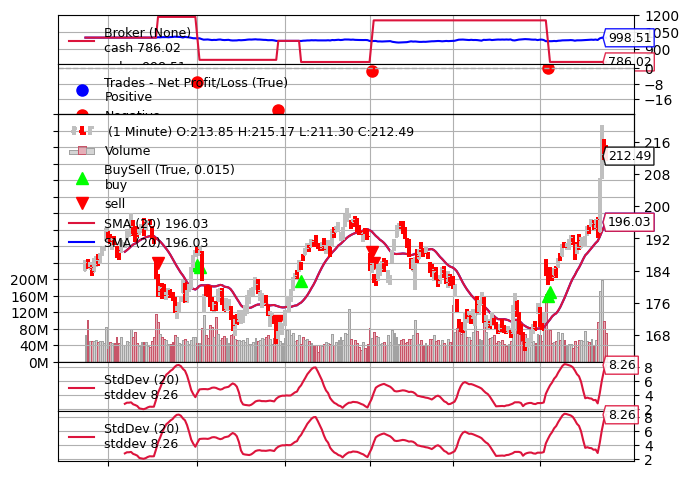

In [9]:
import matplotlib
%matplotlib inline
cerebro, thestrats = run_cerebro(strategy=BackTestStrategy, list_data=data, stake=100, cash=1000)
    #thestrat = thestrats[0]

print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
print("Total point return: ", (cerebro.broker.getvalue() - cerebro.broker.startingcash))

# Plot the results
figs = cerebro.plot(
    iplot=False, 
    style="pincandle", width=60 * 10, height=40 * 10
)


# Finetuning prompt 

In [14]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy.evaluate.metrics import answer_exact_match
from ca_vntl_helper import error_tracking_decorator
from dspy.evaluate import Evaluate

def validate_answer(example, prediction, trace=None):
    print("Example", prediction)
    return prediction.num_retry <= 5 and prediction.answer is not None


evaluate = Evaluate(
    devset = dataset.dev[:3],
    metric = validate_answer,
    num_threads=3,
    display_progress=True,
    display_table=10
)


In [15]:
evaluate(generate_with_assert)

  0%|          | 0/3 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T12:03:34.556699Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T12:03:39.736968Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:03:47.325967Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 1 / 1  (100.0):  33%|███▎      | 1/3 [00:19<00:38, 19.03s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)\n\n    def execute(self):\n        if self.uo > 50 and self.uo[-1] < 50:\n            return 1\n        elif self.uo < 50 and self.uo[-1] > 50:\n            return -1\n        return 0\n```[/INST]',
    num_retry=2
)


ERROR [dspy.primitives.assertions] 2024-06-16T12:03:56.777695Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


Average Metric: 2 / 2  (100.0):  67%|██████▋   | 2/3 [00:34<00:16, 16.70s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```[/INST]
2023-08-21T00:05:00, SELL EXECUTED, Price: 175.07, Cost: -175.07, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -175.07, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Predict

ERROR [dspy.primitives.assertions] 2024-06-16T12:04:10.939955Z [error    ] SuggestionFailed: The code must not obtain the error __bool__ should return bool, returned LineOwnOperation [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix > self.signal and self.trix(-1) < self.signal(-1):
            return 1
        elif self.trix < self.signal and self.trix(-1) > self.signal(-1):
            return -1
        return 0
```


Average Metric: 3 / 3  (100.0): 100%|██████████| 3/3 [00:49<00:00, 16.48s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix[0] > self.signal[0] and self.trix[-1] < self.signal[-1]:
            return 1
        elif self.trix[0] < self.signal[0] and self.trix[-1] > self.signal[-1]:
            return -1
        return 0
```[/INST]
2023-09-18T00:05:00, SELL EXECUTED, Price: 176.48, Cost: -176.48, Comm 0.00
2023-10-10T00:05:00, CLOSE SELL, Price: 178.10, Cost: -176.48, Comm 0.00f
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-12-07T00:05:00, SELL EXECUTED, Price: 193.63, Cost: -193.63, Comm 0.00
2023-12-18T00:05:00, CLOSE SELL, Price: 196.09, Cost: -193.63, Comm 0.00f
2023-12-19T00:05:00, SELL EXECUTED, Price: 196.

,context,question,answer,num_retry,validate_answer
0,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Ultimate Oscillator crosses above 50 and sells when it crosses below 50.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28) def execute(self): if self.uo > 50 and self.uo[-1]...",2,✔️ [True]
1,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Triple Exponential Average (TRIX) is positive and increasing and sells when the TRIX is negative and decreasing.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.trix = bt.ind.TRIX(self.data.close, period=15) def execute(self): if len(self.trix) > 1: if self.trix[0] > 0 and self.trix[0]...",1,✔️ [True]
2,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the TRIX (a triple-smoothed EMA) crosses above the signal line and sells when it crosses below the signal line.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.trix = bt.ind.TRIX(self.data.close, period=15) self.signal = bt.ind.SMA(self.trix, period=9) def execute(self): if self.trix[0] > self.signal[0] and self.trix[-1]...",1,✔️ [True]


100.0

In [16]:
import functools


teleprompter = BootstrapFewShotWithRandomSearch(metric = validate_answer, max_bootstrapped_demos=2, num_candidate_programs=6)

generated_code_student_teacher = teleprompter.compile(
                student=assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), functools.partial(backtrack_handler, max_backtracks=10)), 
                teacher = assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), functools.partial(backtrack_handler, max_backtracks=10)), 
                trainset=dataset.train[:10], 
                valset=dataset.dev[10:15]

)


  0%|          | 0/5 [00:00<?, ?it/s]

ERROR [dspy.primitives.assertions] 2024-06-16T12:06:23.982113Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T12:06:29.786917Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:06:36.486860Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:06:44.726246Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:06:51.305936Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:06:58.159517Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:07:05.258787Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:07:11.199824Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:07:18.647313Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [01:09<04:37, 69.26s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:05

ERROR [dspy.primitives.assertions] 2024-06-16T12:07:31.842009Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] <= 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] >= 0:
            return -1
        return 0
```


ERROR [dspy.evaluate.evaluate] 2024-06-16T12:07:39.092484Z [error    ] Error for example in dev set: 		 invalid syntax (<string>, line 4) [dspy.evaluate.evaluate] filename=evaluate.py lineno=146
Average Metric: 0.0 / 2  (0.0):  40%|████      | 2/5 [01:24<01:52, 37.61s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf[0] > 0 and self.cmf[-1] <= 0:
            return 1
        elif self.cmf[0] < 0 and self.cmf[-1] >= 0:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:07:49.663360Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.high, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.low, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```


Average Metric: 1.0 / 3  (33.3):  60%|██████    | 3/5 [01:43<00:57, 29.00s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```[/INST]
2023-07-10T00:05:00, BUY EXECUTED, Price: 189.26, Cost: 189.26, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 189.26, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -179.69, Comm 0.00f
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-12T00:05:00, CLOSE BUY, Price: 179.49, Cost: 184.94, Comm 0.00
2023-09-13T00:05:00, SELL EXECUTED, Price: 176.51, Cost: -176.51, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Pr

ERROR [dspy.primitives.assertions] 2024-06-16T12:08:04.585562Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'MAE' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae = bt.ind.MAE(self.data.close, period=15, devfactor=2)

    def execute(self):
        if self.data.close > self.mae.upper:
            return 1
        elif self.data.close < self.mae.lower:
            return -1
        return 0
```


Average Metric: 2.0 / 4  (50.0):  80%|████████  | 4/5 [01:57<00:22, 23.00s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae_upper = bt.ind.SMA(self.data.close, period=15) + 2 * bt.ind.StdDev(self.data.close, period=15)
        self.mae_lower = bt.ind.SMA(self.data.close, period=15) - 2 * bt.ind.StdDev(self.data.close, period=15)

    def execute(self):
        if self.data.close > self.mae_upper:
            return 1
        elif self.data.close < self.mae_lower:
            return -1
        return 0
```[/INST]
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-30T00:05:00, CLOSE SELL, Price: 184.94, Cost: -182.13, Comm 0.00f
2023-08-31T00:05:00, BUY EXECUTED, Price: 187.84, Cost: 187.84, Comm 0.00f
2023-09-28T00:05:00, CLOSE BUY, Price: 169.34, Cost: 187.84, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-12

ERROR [dspy.primitives.assertions] 2024-06-16T12:08:20.394066Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T12:08:27.157945Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:08:33.663131Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)
        
    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:08:41.582564Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:08:47.905967Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:08:55.196463Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:09:01.491583Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


Average Metric: 2.0 / 5  (40.0): 100%|██████████| 5/5 [02:53<00:00, 34.75s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, p1=7, p2=14, p3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]
2023-08-28T00:05:00, BUY EXECUTED, Price: 180.09, Cost: 180.09, Comm 0.00f
2023-09-11T00:05:00, CLOSE BUY, Price: 180.07, Cost: 180.09, Comm 0.00
2023-10-06T00:05:00, BUY EXECUTED, Price: 173.80, Cost: 173.80, Comm 0.00f
2023-10-23T00:05:00, CLOSE BUY, Price: 170.91, Cost: 173.80, Comm 0.00
2023-10-25T00:05:00, BUY EXECUTED, Price: 171.88, Cost: 171.88, Comm 0.00f
2023-10-26T00:05:00, CLOSE BUY, Price: 170.37, Cost: 171.88, Comm 0.00
2023-11-01T00:05:00, BUY EXECUTED, Price: 171.00, Cost: 171.00, Comm 0.00f
2023-11-30T00:05:00, CLOSE BUY, Price: 189.84, Cost: 171.00, Comm 0.00
2023-12-04T00:

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T12:09:17.563693Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T12:09:22.625812Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:09:29.657013Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)
        
    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:09:35.891905Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:09:41.319688Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:09:48.175190Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:09:53.145792Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:09:59.027747Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:10:07.216421Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:10:12.552947Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:10:18.960653Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [01:10<04:43, 70.82s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] <= 50:
            return 1
        elif self.uo < 50 and self.uo[-1] >= 50:
            return -1
        return 0
```[/INST]
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)\n\n    def execute(self):\n        if self.uo > 50 and self.uo[-1] <= 50:\n            return 1\n        elif self.uo < 50 and self.uo[-1] >= 50:\n            return -1\n        return 0\n```[/INST]',
    num_retry=10
)


ERROR [dspy.primitives.assertions] 2024-06-16T12:10:28.302919Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'ChaikinMoneyFlow' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind.ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf > 0 and self.cmf[-1] <= 0:
            return 1
        elif self.cmf < 0 and self.cmf[-1] >= 0:
            return -1
        return 0
```


ERROR [dspy.evaluate.evaluate] 2024-06-16T12:10:35.814642Z [error    ] Error for example in dev set: 		 invalid syntax (<string>, line 4) [dspy.evaluate.evaluate] filename=evaluate.py lineno=146
Average Metric: 0.0 / 2  (0.0):  40%|████      | 2/5 [01:27<01:57, 39.06s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cmf = bt.ind ChaikinMoneyFlow(self.data.high, self.data.low, self.data.close, self.data.volume, period=20)

    def execute(self):
        if self.cmf[0] > 0 and self.cmf[-1] <= 0:
            return 1
        elif self.cmf[0] < 0 and self.cmf[-1] >= 0:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:10:45.456240Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.high, self.data.low, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.high, self.data.low, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```


Average Metric: 1.0 / 3  (33.3):  60%|██████    | 3/5 [01:44<00:58, 29.03s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up[0] > self.aroon_down[0]:
            return 1
        elif self.aroon_down[0] > self.aroon_up[0]:
            return -1
        return 0
```[/INST]
2023-07-10T00:05:00, BUY EXECUTED, Price: 189.26, Cost: 189.26, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 189.26, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -179.69, Comm 0.00f
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-12T00:05:00, CLOSE BUY, Price: 179.49, Cost: 184.94, Comm 0.00
2023-09-13T00:05:00, SELL EXECUTED, Price: 176.51, Cost: -176.51, Comm 0.00
2023-10-11T00:05:00, CL

ERROR [dspy.primitives.assertions] 2024-06-16T12:11:01.920854Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'MAE' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae = bt.ind.MAE(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.mae.upper:
            return 1
        elif self.data.close < self.mae.lower:
            return -1
        return 0
```


Average Metric: 2.0 / 4  (50.0):  80%|████████  | 4/5 [01:59<00:23, 23.40s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae_upper = bt.ind.SMA(self.data.close, period=20) + 2 * bt.ind.StdDev(self.data.close, period=20)
        self.mae_lower = bt.ind.SMA(self.data.close, period=20) - 2 * bt.ind.StdDev(self.data.close, period=20)

    def execute(self):
        if self.data.close > self.mae_upper:
            return 1
        elif self.data.close < self.mae_lower:
            return -1
        return 0
```[/INST]
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-09-01T00:05:00, CLOSE SELL, Price: 189.49, Cost: -182.13, Comm 0.00f
2023-09-05T00:05:00, BUY EXECUTED, Price: 188.28, Cost: 188.28, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 188.28, Comm 0.00
2023-11-13T00:05:00, BUY EXECUTED, Price: 185.82, Cost: 185.82, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 185.82, Comm 0.00
2024-01-04T

ERROR [dspy.primitives.assertions] 2024-06-16T12:11:17.436453Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T12:11:23.627923Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:11:31.733639Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


In [13]:
evaluate = Evaluate(
    devset = dataset.dev[10:15],
    metric = validate_answer,
    num_threads=3,
    display_progress=True,
    display_table=10
)

evaluate(generated_code_student_teacher)

Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:05<00:20,  5.19s/it]

Text 
2023-08-21T00:05:00, SELL EXECUTED, Price: 175.07, Cost: -175.07, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -175.07, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
    rationale='',
    answer='',
    num_retry=0
)


Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:08<00:13,  4.34s/it]

Text 
2023-08-21T00:05:00, SELL EXECUTED, Price: 175.07, Cost: -175.07, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -175.07, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
    rationale='',
    answer='',
    num_retry=0
)


Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:13<00:08,  4.26s/it]

Text 
2023-08-21T00:05:00, SELL EXECUTED, Price: 175.07, Cost: -175.07, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -175.07, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
    rationale='',
    answer='',
    num_retry=0
)


Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [00:19<00:05,  5.20s/it]

Text 
2023-08-21T00:05:00, SELL EXECUTED, Price: 175.07, Cost: -175.07, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -175.07, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
    rationale='',
    answer='',
    num_retry=0
)


Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]

Text 
2023-08-21T00:05:00, SELL EXECUTED, Price: 175.07, Cost: -175.07, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -175.07, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
    rationale='',
    answer='',
    num_retry=0
)


,context,question,rationale,answer,num_retry,validate_answer
0,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Ultimate Oscillator crosses above 50 and sells when it crosses below 50.,,,0,✔️ [True]
1,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Chaikin Money Flow (CMF) crosses above the zero line and sells when it crosses below the zero line.,,,0,✔️ [True]
2,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Aroon Up crosses above the Aroon Down and sells when the Aroon Down crosses above the Aroon Up.,,,0,✔️ [True]
3,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Moving Average Envelopes indicator's close crosses above its upper band and sells when it crosses below its lower...,,,0,✔️ [True]
4,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Ultimate Oscillator crosses above 50 and sells when it crosses below 50.,,,0,✔️ [True]


100.0

In [ ]:

# Save the generated code module
generated_code_student_teacher.save("generated_code.json")

In [55]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
# @error_tracking_decorator

config = dict(max_bootstrapped_demos=2, max_labeled_demos=4, num_candidate_programs=2, num_threads=6)
teleprompter = BootstrapFewShotWithRandomSearch(metric=validate_answer, **config)
optimized_qa = teleprompter.compile(student=GenerateCodeWithAssert, trainset=dataset.train[:10], valset=dataset.dev[10:15])

TypeError: BaseModule.reset_copy() missing 1 required positional argument: 'self'